## Setup

In [1]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [2]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

##### Likelihood in a Mixture Model:

$$ p(x_n|\Theta) = \sum_{k=1}^{K} \, \pi_k \, p(x_n|\theta_k)$$


$$ \log p(X|\Theta) = \sum_{n=1}^{N} \, \log(\, \sum_{k=1}^{K} \, \pi_k \, p(x|\theta_k) \, )$$ 



## Truncated curves exploration

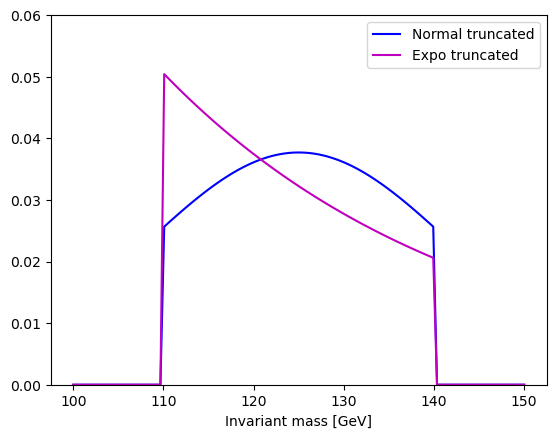

In [3]:
x = np.linspace(100,150,120)
mu = 125
sigma = 17
plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', label='Normal truncated')
b = 30
Lambda = 0.03
plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', label = 'Expo truncated')
plt.ylim(0,0.06)
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

In [4]:
sum(stats.truncnorm.pdf(x,(110-125)/17,(140-125)/17,125,17))*50/120

0.9980516360413421

In [5]:
sum(stats.truncexpon.pdf(x-110,30*0.03, loc=0, scale = 1/0.03))*50/120

1.0005555373368886

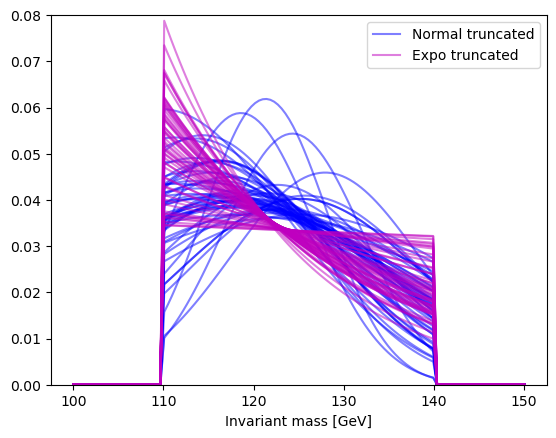

In [6]:
x = np.linspace(100,150,120)
np.random.seed(1)
for i in range(50):
    mu = np.random.normal(117,5)
    sigma = np.random.normal(16,4)
    if i==0: plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5, label='Normal truncated')
    plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5)
for j in range(50):
    b = 30
    Lambda = abs(np.random.normal(0.03,0.02))
    if j==0: plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', alpha=0.5, label = 'Expo truncated')
    plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-',  alpha=0.5)
plt.ylim(0,0.08)
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

## Generate synthetic data

In [7]:
b=30
Lambda = 0.06
mu=120
sigma=7
###################
data = []
p = [0.7,0.3] # p[0] is background, p[1] is signal
np.random.seed(seed=0)
for i in range(1000):
    # Pay attention here: using binomial with p[1] means that if draws 1's then it is signal
    if np.random.binomial(1,p[1], size=1)[0] == 1: 
        data.append(list(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=2))+[1])
    else:
        data.append(list(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=2))+[0])
    
        

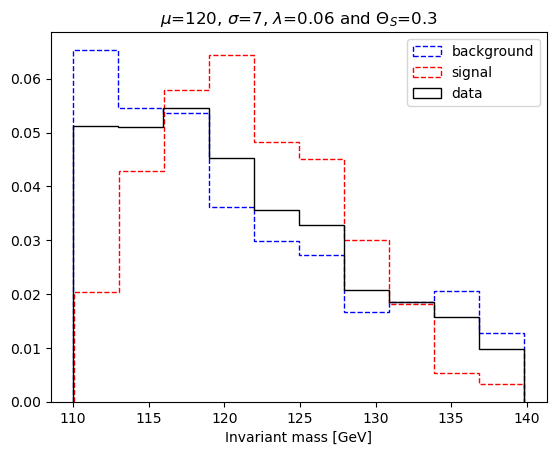

In [8]:
plt.hist([x[1] for x in data if x[2]==0], histtype='step', linestyle='dashed', color='blue', density=1, label = 'background')
plt.hist([x[1] for x in data if x[2]==1],histtype='step', linestyle='dashed', color='red',  density=1, label='signal')
plt.hist([x[1] for x in data],histtype='step', density=1, color='black', label='data')
plt.xlabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

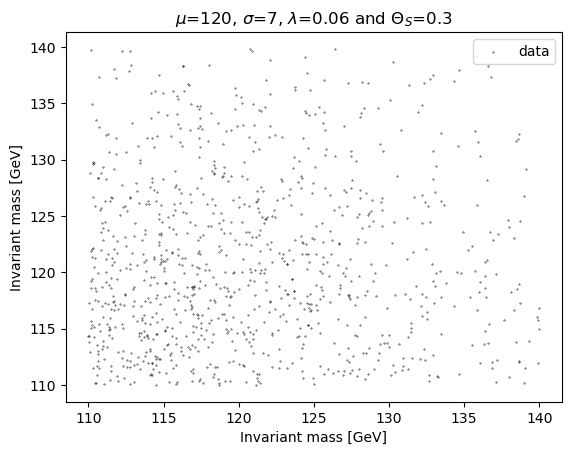

In [9]:
plt.scatter([x[0] for x in data[:5000]], [x[1] for x in data[:5000]], color='black', s=0.1, label='data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

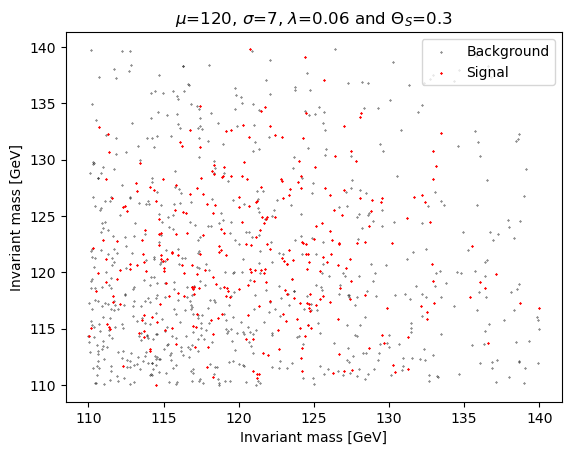

In [10]:
plt.scatter([x[0] for x in data if x[2]==0], [x[1] for x in data if x[2]==0], color='black', s=0.1, label='Background')
plt.scatter([x[0] for x in data if x[2]==1], [x[1] for x in data if x[2]==1], color='red', marker='x', s=0.5, label='Signal')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

## Stan inference

In [11]:
my_model = """
data {
 int <lower=0> N; // number of datapoints
 real L, U; // lower and upper limits of the observables (i.e. how to truncate the distributions)
 array[N,2] real<lower=L, upper=U> y;  // there are 2 observables per datapoint
 real mu0, sigma0, mu1, sigma1, mu2, sigma2, t1, t2;  // hyperparameters for the parameters priors
}

parameters {
  real<lower=0> mu; 
  real<lower=0> sigma;
  real<lower=0> lambda0;
  simplex[2] theta;  
}

model {
    vector[2] lp;
    mu ~ normal(mu0, sigma0);
    sigma ~ cauchy(mu1, sigma1);
    lambda0 ~ normal(mu2, sigma2);
    theta ~ dirichlet([t1,t2]);
    
   for (n in 1:N) {
    lp[1] =   exponential_lpdf( y[n,1] - L | lambda0)             
            - exponential_lcdf( U - L | lambda0) 
            + exponential_lpdf( y[n,2] - L| lambda0)
            - exponential_lcdf( U - L | lambda0);
     lp[2] =  normal_lpdf(y[n,1] | mu, sigma)
            - log_diff_exp( normal_lcdf( U | mu, sigma), normal_lcdf( L | mu, sigma) )             
            + normal_lpdf(y[n,2] | mu, sigma)
            - log_diff_exp( normal_lcdf( U | mu, sigma), normal_lcdf( L | mu, sigma) );

     // Pay attention here: theta[1] is associated to background, and theta[2] to signal, since we don't have theta[0]
     target += log_mix(theta, lp);                        
     };
}
"""

In [12]:
# Define hyperparameters that determine priors
mu0 = 120
sigma0 = 6
mu1 = 8
sigma1 =5
mu2 = Lambda*0.8
sigma2 = Lambda*0.2       
t1 = 1
t2 = 1

In [13]:
data_held = [[x[0], x[1]] for x in data[800:1000]]
len(data_held)

200

In [14]:
# Observe that we only train with the first 5k datapoints!
passed_data = [[x[0], x[1]] for x in data[:800]]
my_data = {'N': len(passed_data), 
           'y': passed_data, # Only first 2 columns. I.e. not the class.
           'mu0': mu0,
           'sigma0': sigma0,
           'mu1':mu1,
           'sigma1': sigma1,
           'mu2': mu2,
           'sigma2': sigma2,
           't1' : t1,
           't2' : t2,
           'L' : 110.0,
           'U' : 140.0
          }

In [15]:
model = stan.build(my_model, data=my_data, random_seed=0);

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_s99t6g23/model_5x5ykgah.stan', line 21, column 4: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [16]:
fit = model.sample(num_chains=4, num_samples=1000, delta=0.80)


Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sampling:  41% (3300/8000)
Samplin

## Analyze results

In [17]:
df = fit.to_frame() 
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,lambda0,theta.1,theta.2
draws,,,,,,,,,,,,
0,-5245.707006,0.999318,0.158195,4.0,31.0,0.0,5246.555910,117.054732,7.456115,0.046560,0.681292,0.318708
1,-5246.915034,0.954317,0.159452,3.0,15.0,0.0,5251.819844,119.078980,6.984579,0.059564,0.775081,0.224919
2,-5250.333321,0.994731,0.160468,4.0,31.0,0.0,5253.395190,113.655490,9.122535,0.024550,0.505709,0.494291
3,-5247.628465,0.914953,0.145596,3.0,7.0,0.0,5249.756980,120.312272,5.768229,0.048524,0.802550,0.197450
4,-5245.258981,0.985996,0.158195,4.0,19.0,0.0,5246.931914,119.728063,6.716447,0.057290,0.723015,0.276985
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-5246.164490,0.989239,0.145596,4.0,23.0,0.0,5246.921725,119.738640,7.651294,0.056482,0.610499,0.389501
3996,-5246.660712,0.986884,0.158195,4.0,15.0,0.0,5251.463650,118.473129,10.445223,0.061431,0.499035,0.500965
3997,-5245.566636,0.945942,0.159452,3.0,7.0,0.0,5248.707180,120.820498,5.665638,0.057272,0.794429,0.205571


In [18]:
# Let's diagnose the sampling.  rhat is a variable that measures how good the chains have reached a stationary state
# rhat < 1.05 is good enough
azdata = az.from_pystan(fit)
summary = az.summary(azdata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda0,0.051,0.009,0.033,0.068,0.000,0.000,1090.0,1001.0,1.01
mu,117.304,2.556,112.389,121.739,0.098,0.069,700.0,1515.0,1.01
sigma,8.936,2.175,5.003,12.919,0.077,0.054,791.0,1220.0,1.01
theta[0],0.582,0.169,0.266,0.872,0.006,0.004,796.0,1415.0,1.01
theta[1],0.418,0.169,0.128,0.734,0.006,0.004,796.0,1415.0,1.01


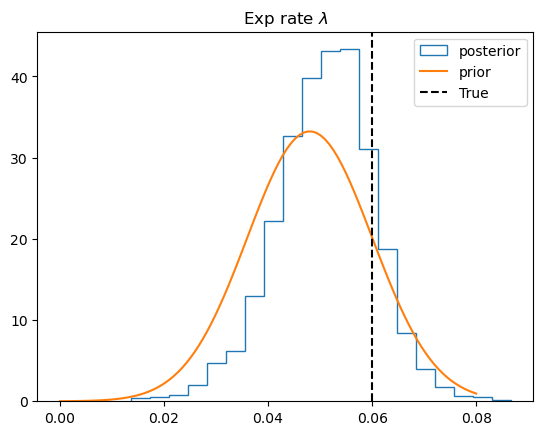

In [19]:
x=np.linspace(0,0.08,100)
plt.hist(df['lambda0'], histtype='step', density=1, bins=20, label='posterior')
plt.plot(x, stats.norm.pdf(x, mu2, sigma2), label='prior')
plt.axvline(x=Lambda, linestyle='dashed', color='black', label='True')
plt.title('Exp rate $\lambda$')
plt.legend()
plt.show()

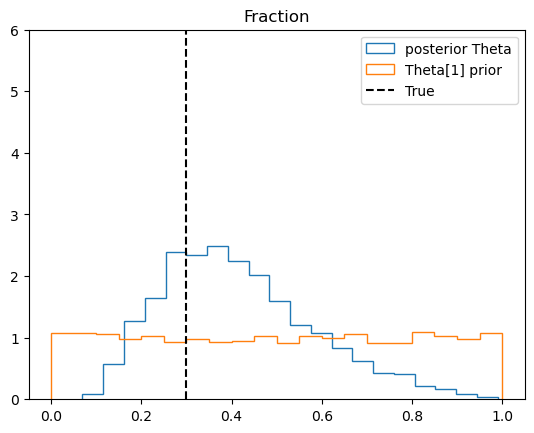

In [23]:
x=np.linspace(0,0.15,100)
tmp = np.random.dirichlet([t1,t2], size=5000)
plt.hist(df['theta.2'], histtype='step', density=1, bins=20, label='posterior Theta')
plt.hist([x[0] for x in tmp], density=1, histtype='step', bins=20, label='Theta[1] prior')
#plt.hist([x[1] for x in tmp], density=1, histtype='step', bins=20, label='Theta[2] prior')
plt.axvline(x=p[1], linestyle='dashed', color='black', label='True')
plt.ylim(0,6)
plt.title('Fraction')
plt.legend()
plt.show()

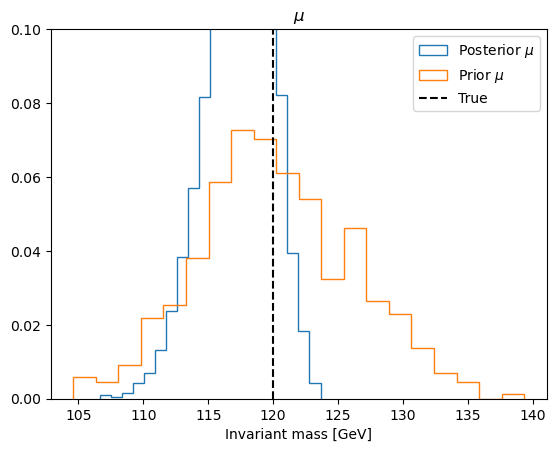

In [21]:
x=np.linspace(100,150,100)
plt.hist(df['mu'], histtype='step', density=1, bins=20, label='Posterior $\mu$')
plt.hist([x for x in np.random.normal(mu0,sigma0,size=500)], density=1, histtype='step', bins=20, label='Prior $\mu$')
plt.axvline(x=mu, linestyle='dashed', color='black', label='True')
plt.ylim(0,0.1)
plt.title('$\mu$')
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

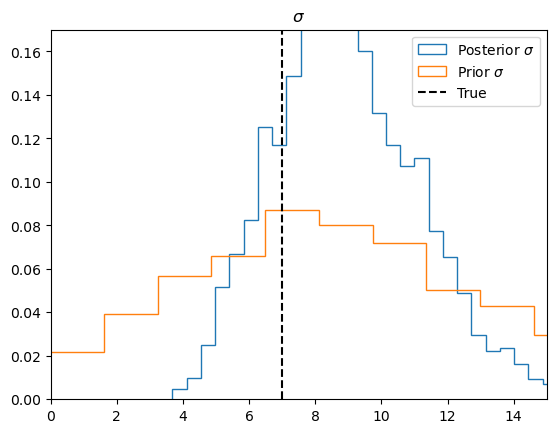

In [24]:
x=np.linspace(0,15,100)
plt.hist(df['sigma'], histtype='step', density=1, bins=30, label='Posterior $\sigma$')
plt.hist([x for x in np.random.normal(mu1,sigma1,size=1500)], density=1, histtype='step', bins=20, label='Prior $\sigma$')
plt.axvline(x=sigma, linestyle='dashed', color='black', label='True')
plt.ylim(0,0.17)
plt.xlim(0,15)
plt.title('$\sigma$')
plt.legend()
plt.show()

## Posterior predictive check

#### Visualize the problem

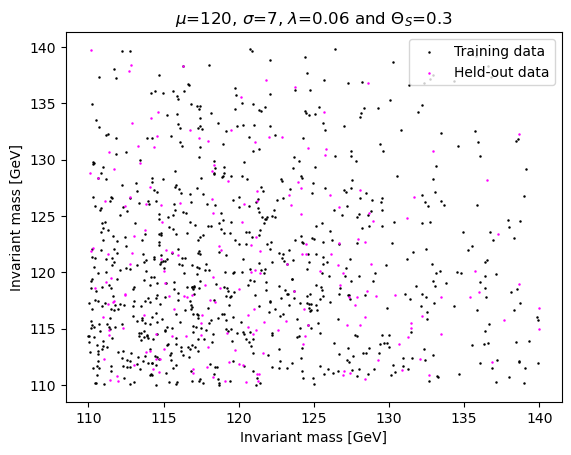

In [25]:
plt.scatter([x[0] for x in passed_data],[x[1] for x in passed_data], color='black',  s=0.6, label='Training data')
plt.scatter([x[0] for x in data_held],[x[1] for x in data_held], color='magenta',  s=0.6, label='Held-out data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

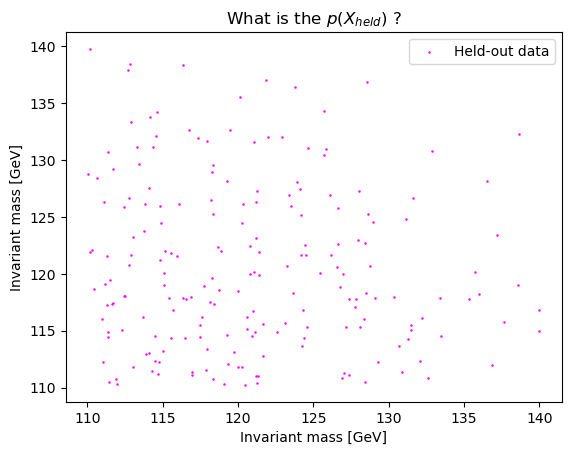

In [26]:
#plt.scatter([x[0] for x in passed_data],[x[1] for x in passed_data], color='black',  s=0.6, label='Training data')
plt.scatter([x[0] for x in data_held],[x[1] for x in data_held], color='magenta',  s=0.6, label='Held-out data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('What is the $p(X_{held})$ ?')
plt.legend()
plt.show()

#### Generate tons of synthetic data to obtain the PDF of the inferred model

In [27]:
%%time
np.random.seed(0)
sinthetic = []
b = 30 # Truncated Exponential span
tons = 1000000
repeat = 10 # How many sinthetica data with the same sample of the 
samples = np.random.choice(range(len(df)), size=int(tons/repeat))
for i in range(len(samples)):
    if i%50000 == 0: print(i)
    # Pay attention here: the binomial argument should be the expected signal fraction, which is theta[2] (read in detail above and below how we use p)
    p = df.iloc[samples[i]]['theta.2'] 
    Lambda = df.iloc[samples[i]]['lambda0']
    mu = df.iloc[samples[i]]['mu']
    sigma = df.iloc[samples[i]]['sigma']
    # Here p is the probability of getting a 1, hence we should assign 1 to signal because p=theta.2
    classes = np.random.binomial(1,p,repeat) # Get repeated samples of a binomial with parameter of the signal fraction
    for j in range(repeat):
        if classes[j] == 0:
            sinthetic.append(list(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=2)))
        else:
            sinthetic.append(list(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=2)))                                

0
50000
CPU times: user 37 s, sys: 493 ms, total: 37.5 s
Wall time: 36.8 s


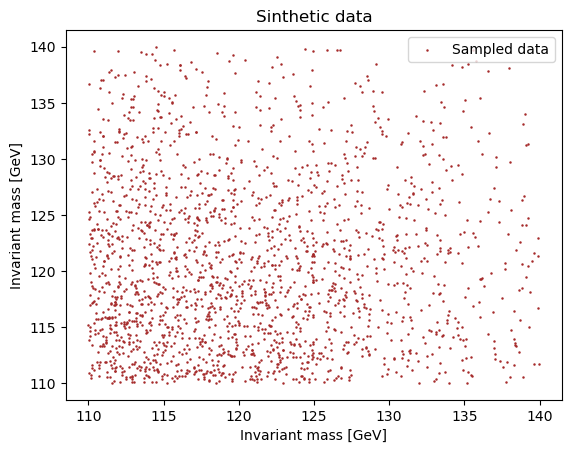

In [28]:
#plt.scatter([x[0] for x in passed_data],[x[1] for x in passed_data], color='black',  s=0.6, label='Training data')
plt.scatter([x[0] for x in sinthetic[:2000]],[x[1] for x in sinthetic[:2000]], color='brown',  s=0.6, label='Sampled data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('Sinthetic data')
plt.legend()
plt.show()

In [29]:
# setup definitions
xmin, xmax, xbins = 110, 140, 15
ymin, ymax, ybins = 110, 140, 15
grid = np.zeros([ybins,xbins])

xstep = (xmax-xmin)/xbins
ystep = (ymax-ymin)/ybins
# fill the grid
for i in range(len(sinthetic)):
    if i%100000 == 0: print(i)
    xpos = int((sinthetic[i][0]-xmin)/xstep)
    ypos = ybins - 1 - int((sinthetic[i][1]-ymin)/ystep)
    grid[ypos][xpos] += 1

# Normalize
gridlog = np.zeros([ybins,xbins])
total = len(sinthetic)
for i in range(ybins):
    for j in range(xbins):
        grid[i][j] = grid[i][j]/total
        gridlog[i][j] = np.log(grid[i][j]/total)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


#### Heat-map as histogram for the PDF

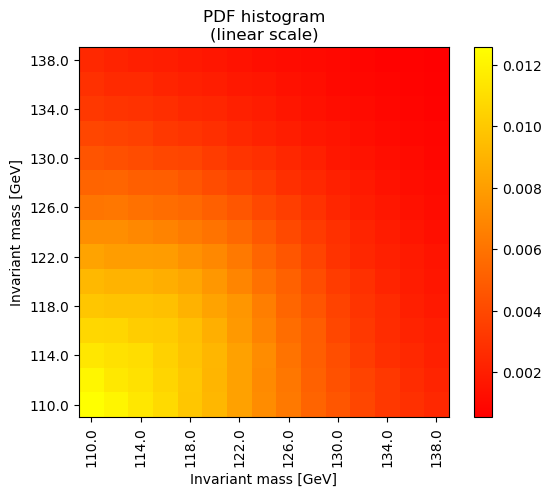

In [30]:
#tt = np.random.random((12, 12)) 
plt.imshow(grid, cmap='autumn', interpolation='nearest') 
plt.colorbar()   
plt.title("PDF histogram\n(linear scale)")
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.xticks([x for x in range(0,xbins+1, int(xstep))],[xmin + (x*xstep) for x in range(0,xbins+1, int(xstep))], rotation=90)
plt.yticks([y for y in range(0,ybins+1, int(ystep))],[ymax - ystep - (y*ystep) for y in range(0,ybins+1, int(ystep))])
plt.show() 

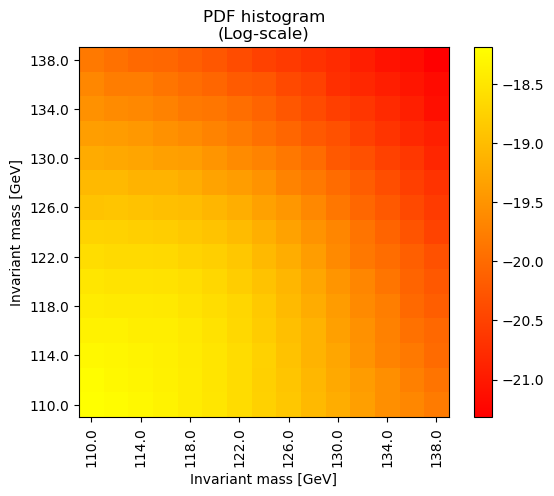

In [31]:
#tt = np.random.random((12, 12)) 
plt.imshow(gridlog, cmap='autumn', interpolation='nearest') 
plt.colorbar()   
plt.title("PDF histogram\n(Log-scale)")
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.xticks([x for x in range(0,xbins+1, int(xstep))],[xmin + (x*xstep) for x in range(0,xbins+1, int(xstep))], rotation=90)
plt.yticks([y for y in range(0,ybins+1, int(ystep))],[ymax - ystep - (y*ystep) for y in range(0,ybins+1, int(ystep))])
plt.show() 

$$  p(x_n | X ) = \int p(x_n | z_i )\, p(z_i | X )\, dz_i $$

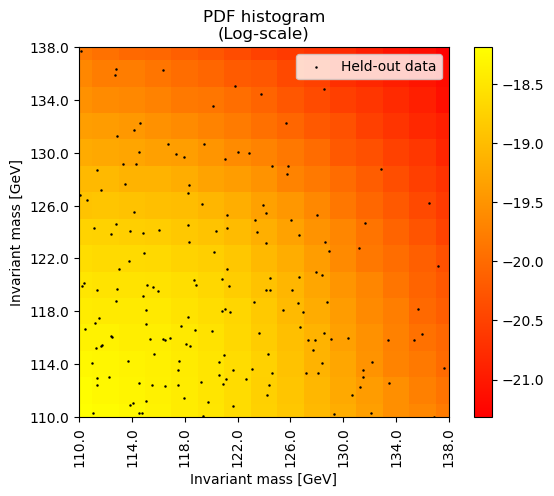

In [32]:
#tt = np.random.random((12, 12)) 
plt.imshow(gridlog, cmap='autumn', interpolation='nearest') 
plt.colorbar()   
plt.scatter([(x[0]-110)/2 for x in data_held],[(140-x[1])/2 for x in data_held], color='black',  s=0.6, label='Held-out data')
plt.title("PDF histogram\n(Log-scale)")
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.xlim(0,xbins-xstep/2)
plt.ylim(ybins-ystep/2, 0)
plt.xticks([x for x in range(0,xbins+1, int(xstep))],[xmin + (x*xstep) for x in range(0,xbins+1, int(xstep))], rotation=90)
plt.yticks([y for y in range(0,ybins+1, int(ystep))],[ymax - ystep - (y*ystep) for y in range(0,ybins+1, int(ystep))])
plt.legend()
plt.show() 

#### Compute probability of $X_{held}$

In [33]:
def lp_data(l):
    lp = 0
    for i in range(len(l)):    
        xpos = int((l[i][0]-xmin)/xstep)
        ypos = ybins - 1 - int((l[i][1]-ymin)/ystep)
        lp += gridlog[ypos][xpos]
    return lp

In [34]:
lp_held = lp_data(data_held)
print('Probability of the data held-out Log(p(X_{held})) =',lp_held)

Probability of the data held-out Log(p(X_{held})) = -3792.9196585279674


#### Generate replicas

In [35]:
%%time
np.random.seed(500)
replicas0 = []
b = 30 # Truncated Exponential span
tons = 300000
repeat = 10 # How many sinthetica data with the same sample of the 
samples = np.random.choice(range(len(df)), size=int(tons/repeat))
for i in range(len(samples)):
    p = df.iloc[samples[i]]['theta.2']
    Lambda = df.iloc[samples[i]]['lambda0']
    mu = df.iloc[samples[i]]['mu']
    sigma = df.iloc[samples[i]]['sigma']
    classes = np.random.binomial(1,p,repeat) # Get repeat sampels of a binomial with parameter of the sampled
    for j in range(repeat):
        if classes[j] == 0:
            replicas0.append(list(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=2)))
        else:
            replicas0.append(list(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=2)))                                

CPU times: user 10.9 s, sys: 116 ms, total: 11 s
Wall time: 10.9 s


In [36]:
replicas = []
for k in range(int(len(replicas0)/len(data_held) - 1)):
    replicas.append(replicas0[k*len(data_held):(k+1)*len(data_held)])

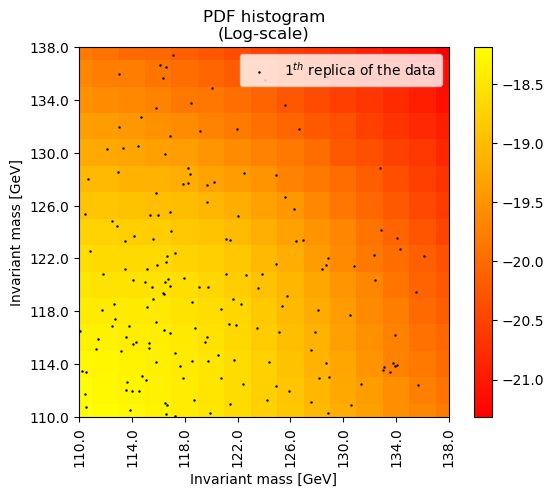

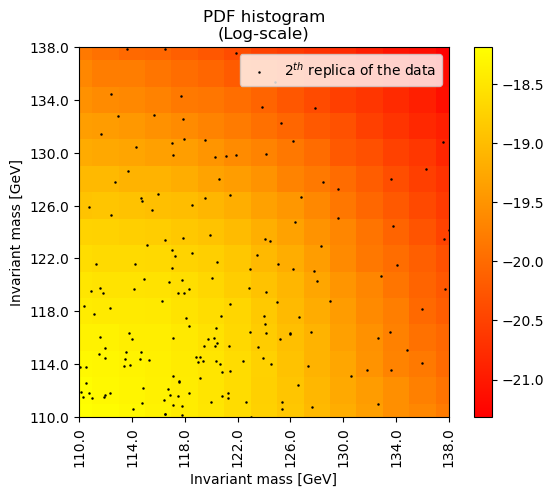

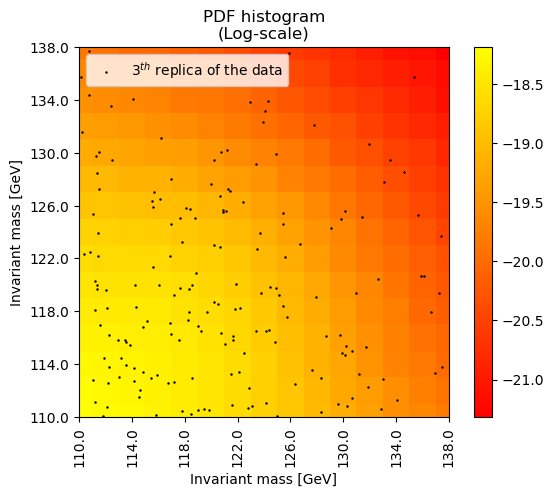

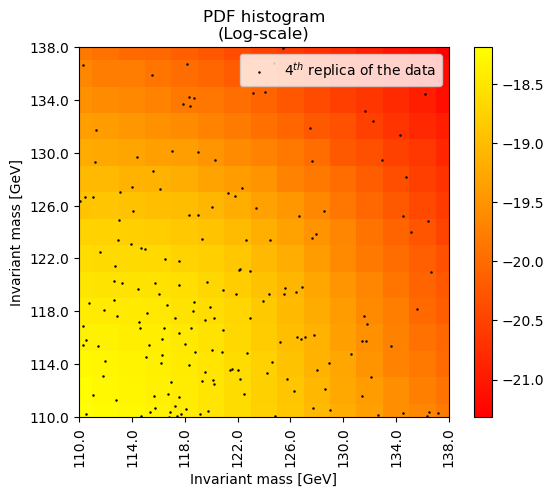

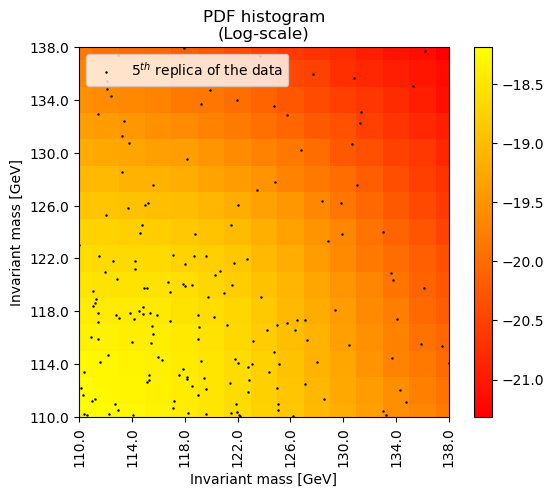

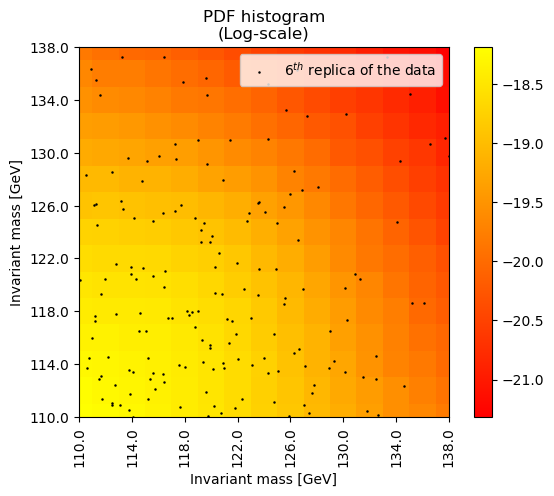

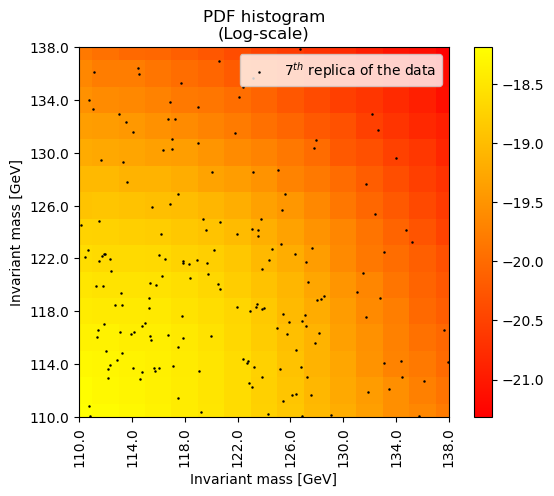

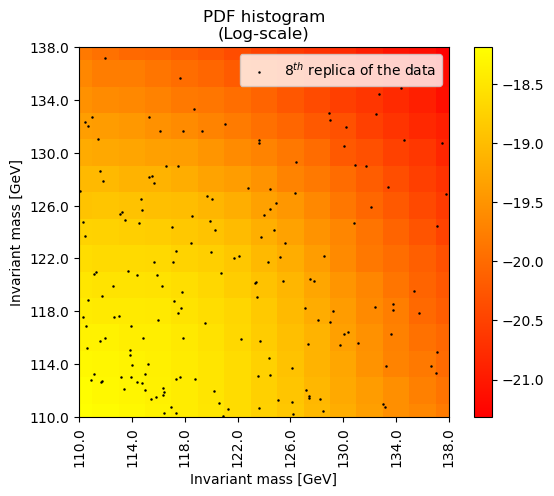

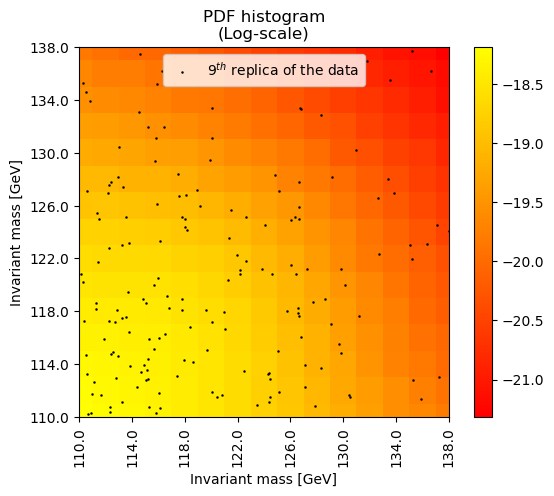

In [37]:
for i in range(1,10):
    plt.imshow(gridlog, cmap='autumn', interpolation='nearest') 
    plt.colorbar()   
    plt.scatter([(x[0]-110)/2 for x in replicas[i]],[(140-x[1])/2 for x in replicas[i]], color='black',  s=0.6, label=str(i)+'$^{th}$ replica of the data')
    plt.title("PDF histogram\n(Log-scale)")
    plt.xlabel('Invariant mass [GeV]')
    plt.ylabel('Invariant mass [GeV]')
    plt.xlim(0,xbins-xstep/2)
    plt.ylim(ybins-ystep/2, 0)
    plt.xticks([x for x in range(0,xbins+1, int(xstep))],[xmin + (x*xstep) for x in range(0,xbins+1, int(xstep))], rotation=90)
    plt.yticks([y for y in range(0,ybins+1, int(ystep))],[ymax - ystep - (y*ystep) for y in range(0,ybins+1, int(ystep))])
    plt.legend()
    plt.savefig('figs/replicas_'+str(i)+'.png')
    plt.show() 

In [38]:
# Count how many times the replicas prob is less than the held_out
count = 0
total = 0
lp_replicas = []
for i in range(len(replicas)):
    lp_replicas.append(lp_data(replicas[i]))
    if lp_replicas[-1] < lp_held:
        count += 1
    total += 1    

count/total

0.7458305537024683

In [128]:
# Extract the relevant info from the histogram plot for the next computations
a = plt.hist(lp_replicas, histtype='step', density=1, bins=15, label='Replicas of the data');
plt.close()

##### Compute the probability of having less probability than the held-out data

https://arxiv.org/pdf/1805.06826

In [120]:
x00 = [a[1][0]]
y00 = [a[0][0], a[0][0]]
for i in range(1,11):
    x00 = x00 + [ a[1][i], a[1][i]]
    y00 = y00 + [a[0][i], a[0][i]]
x00.append(a[1][11])

In [125]:
0.5*sum(y00)*(x00[1]-x00[0])

0.8664440734558028

$$ p \left( \, p(X^{rep}_{held}) < p(X_{held}) \right) = 0.86 $$

##### Compute the area of the histogram where the p is less than the p(data)

In [105]:
xslow = [a[1][0], a[1][1], a[1][1],a[1][2], a[1][2], a[1][3], a[1][3], a[1][4], a[1][4], a[1][5]]
yslow = [a[0][0], a[0][0], a[0][1], a[0][1],a[0][2], a[0][2], a[0][3], a[0][3], a[0][4], a[0][4]]

In [95]:
xsup = [a[1][11], a[1][11],a[1][12], a[1][12], a[1][13], a[1][13], a[1][14], a[1][14], a[1][15]]
ysup = [a[0][10], a[0][11], a[0][11],a[0][12], a[0][12], a[0][13], a[0][13], a[0][14], a[0][14]]

In [104]:
score = (sum(yslow[::2]) + sum(ysup[::2])) * (a[1][12]-a[1][11])
score

0.3722871452420701

$$ p \left( \, p^2(X^{rep}_{held}) < p^2(X_{held}) \right) = 0.37 $$

#### Plotting

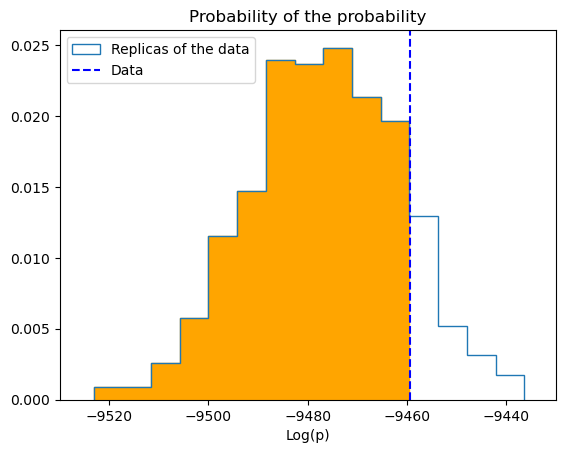

In [122]:
a = plt.hist(lp_replicas, histtype='step', density=1, bins=15, label='Replicas of the data')
plt.axvline(lp_held, linestyle='dashed', color='blue', label='Data')
#plt.fill_between(xslow, yslow, color='orange')
#plt.fill_between(xsup, ysup, color='orange')
plt.fill_between(x00, y00, color='orange')
plt.xlim(-9530,-9430)
plt.xlabel('Log(p)')
plt.title('Probability of the probability')
plt.legend()
plt.savefig('figs/posterior-predictive-check_03.png')
plt.show()